In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
from tifffile import imread
from scipy.ndimage import gaussian_filter
from scipy.sparse import csr_matrix, isspmatrix

In [ ]:
adata_exp0 = anndata.read_h5ad('C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/spatial/counts_CPc_exp0_BA28.h5ad')

In [ ]:
adata_Yao = anndata.read_h5ad(
    'C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/sc/Yao_150kcells_subsample_with_annotations_sparse_subset.h5ad')

In [ ]:
def get_negative_marker_dict(adata_sp: AnnData, adata_sc: AnnData, key: str='celltype'):
    """add dictionary of negative marker genes for different celltypes
    
    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    key : str
        Celltype key in adata_sp.obs and adata_sc.obs

    Returns
    -------
    neg_marker_dict : dict[string: list]
        dictionary with celltypes as keys and corresponding negative marker genes as values
    """

    # Set threshold parameters
    min_number_cells=10 # minimum number of cells belonging to a cluster to consider it in the analysis
    max_ratio_cells=0.005 # maximum ratio of cells expressing a marker to call it a negative marker gene-ct pair

    #check that genes in spatial data is subset of genes in single cell data
    adata_sp = adata_sp[:,adata_sp.var_names.isin(adata_sc.var_names)]

    # Subset adata_sc to genes of spatial data
    adata_sc = adata_sc[:,adata_sp.var_names]           
    
    adata_sc.layers["raw"] = adata_sc.X

    # TMP fix for sparse matrices, ideally we don't convert, and instead have calculations for sparse/non-sparse
    if isspmatrix(adata_sc.layers["raw"]):                                  
        adata_sc.layers["raw"] = adata_sc.layers["raw"].toarray()

    # Get cell types that we find in both modalities
    shared_celltypes = adata_sc.obs.loc[adata_sc.obs[key].isin(adata_sp.obs[key]),key].unique()
    
    # Filter cell types by minimum number of cells
    celltype_count_sc = adata_sc.obs[key].value_counts().loc[shared_celltypes]
    celltype_count_sp = adata_sc.obs[key].value_counts().loc[shared_celltypes]   
    ct_filter = (celltype_count_sc >= min_number_cells) & (celltype_count_sp >= min_number_cells)
    celltypes = celltype_count_sc.loc[ct_filter].index.tolist()             
    
    
    # Filter cells to eligible cell types
    adata_sc = adata_sc[adata_sc.obs[key].isin(celltypes)]
    genes = adata_sc.var_names
    
    # Get ratio of positive cells per cell type
    pos_exp_sc = pd.DataFrame(adata_sc.layers["raw"] > 0,columns=adata_sp.var_names)     
    pos_exp_sc['celltype'] = list(adata_sc.obs[key])
    ratio_celltype_sc = pos_exp_sc.groupby('celltype').mean()
    
    # Get gene-cell type pairs with negative marker expression
    neg_marker_mask = np.array(ratio_celltype_sc < max_ratio_cells)
    

    neg_marker_mask = pd.DataFrame(neg_marker_mask, columns = genes, index = ratio_celltype_sc.index)   
    neg_marker_dict = {celltype: [] for celltype in celltypes}

    for celltype, row in neg_marker_mask.iterrows():
        for gene in genes:
            if row[gene]:
                neg_marker_dict[celltype].append(gene)

    return neg_marker_dict


In [ ]:
#test get_negative_marker_dict
dict_exp0 = get_negative_marker_dict(adata_sp = adata_exp0, adata_sc = adata_Yao, key ='celltype')
len(dict_exp0.keys())

In [ ]:
def get_neg_mark_read_in_corr_ct(adata_sp: AnnData, adata_sc: AnnData):

    """add column in_correct_celltype and 

       in_correct_celltype is TRUE, if gene is in_correct_celltype, else FALSE. 

       Parameters
       ----------
       adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
       adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    
       Returns
       ----------
       pandas DataFrame

    """

    df = adata_sp.uns["spots"]  
   
    neg_marker_dict = get_negative_marker_dict(adata_sp, adata_sc)

    celltypes = list(neg_marker_dict.keys())   

    df["in_correct_celltype"] = "Unknown"
    df.loc[df["celltype"].isin(celltypes), "in_correct_celltype"] = "True"

    for ct in celltypes:
      df.loc[(df["Gene"].isin(neg_marker_dict[ct])) & (df["celltype"] == ct), 'in_correct_celltype'] = "False"      
    
    return df

In [ ]:
#test get_neg_mark_read_in_corr_ct
df_exp0 = get_neg_mark_read_in_corr_ct(adata_sp=adata_exp0, adata_sc=adata_Yao)
print(df_exp0['x'].min(), df_exp0['x'].max(), df_exp0['y'].min(), df_exp0['y'].max())

In [ ]:
x_min, x_max, y_min, y_max = df_exp0['x'].min(), df_exp0['x'].max(), df_exp0['y'].min(), df_exp0['y'].max()

In [ ]:
def plot_spots(spots: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, show_ticks: bool = False):
    """plot gene spots
     
     spot is red if entry in 'in_correct_celltype' is False, blue if True, grey if unknown

     Parameters
     ----------
     spots : pd.DataFrame
          pd.DataFrame with columns: gene, x, y, celltype, in_correct_celltype
     x_min : int, x_max : int, y_min : int, y_max : int 
          crop coordinates
     image : NDArray
          read from image of dapi stained cell-nuclei
     show_ticks : bool 
          default False, show no ticks or labels
    """

    df = spots
    
    s_factor =  150000/((x_max-x_min)**2)                  
    
    fig, ax = plt.subplots()

    ax.axis([x_min, x_max, y_max, y_min])        
    ax.imshow(image,cmap = "binary_r") 

    #filter spots
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]
    
    if show_ticks:
        ax.tick_params(which='both', direction='in')
    else:
        ax.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)

    ax.scatter(df.loc[df['in_correct_celltype']=="Unknown","x"],df.loc[df['in_correct_celltype']=="Unknown","y"], s = 0.3*s_factor, color = "grey")
    ax.scatter(df.loc[df['in_correct_celltype']=="True","x"],df.loc[df['in_correct_celltype']=="True","y"], s = 0.5*s_factor, color = "blue")
    ax.scatter(df.loc[df['in_correct_celltype']=="False","x"],df.loc[df['in_correct_celltype']=="False","y"], s = 1*s_factor, color = "red")
    
    

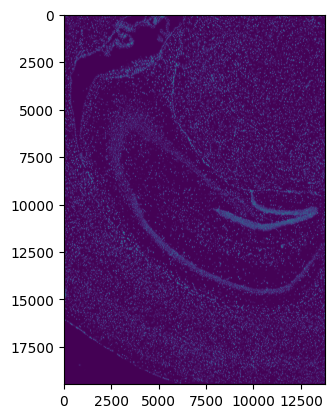

In [131]:
image = imread(r"C:\Users\mdichgan\Documents\Helmholtz\send_to_Jakob\tif_images\background.tiff")
plt.imshow(image)

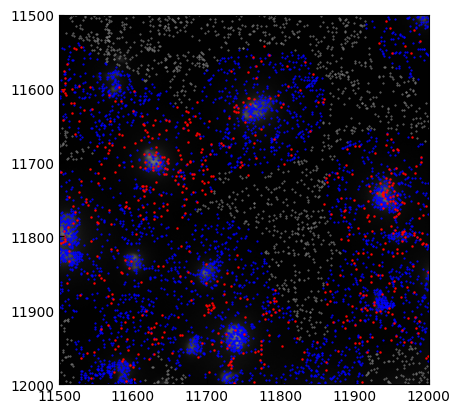

In [134]:
plot_spots(df_exp0, 11500,12000,11500,12000,image,show_ticks=True)

In [140]:
def get_neg_spot_density(spots: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """get density array of negative spots

    Parameters
    ----------
    spots : pd.DataFrame
        pd.DataFrame with columns: gene, x, y, celltype, in_correct_celltype
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of negative marker reads per bin
    range : range of binning 
    """
     
    if (x_min is None or x_max is None or y_min is None or y_max is None) and image is None:
        raise ValueError("please provide an image or crop")         
        
    if image is None:
        range = [[x_min,x_max],[y_min,y_max]]
    
    else:
        range = [[0,image.shape[0]],[0,image.shape[1]]]
    
    np.seterr(invalid='ignore')
    #filter spots
    df = spots
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]

    true_spots = df.loc[df['in_correct_celltype'] == "True"]
    x_t = true_spots['x']
    y_t = true_spots['y']
    H_t, x_edges, y_edges = np.histogram2d(x_t, y_t, bins = bins, range = range)
    # Histogram does not follow Cartesian convention,
    # therefore transpose H for visualization purposes.
    H_t = H_t.T

    false_spots = df.loc[df['in_correct_celltype'] == "False"]
    x_f = false_spots['x']
    y_f = false_spots['y']
    H_f, x_edges, y_edges = np.histogram2d(x_f, y_f, bins = bins, range = range)
    H_f = H_f.T


    H = H_f/(H_t+H_f)    #ignore "Unknown" spots in density calculation, since it could be both True or False
    H[np.isnan(H)] = 0      #no negative marker wrongly assigned where no spots

 
    return H,range
    

In [145]:
A,r = get_neg_spot_density(df_exp0,10000,12500,10000,12500,image=None,bins = 20)
A.shape

(20, 20)

In [ ]:
def plot_neg_spot_density(spots: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int,
                       image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    
    """plot neg spot density

    Parameters
    ----------
    spots : pd.DataFrame
        pd.DataFrame with columns: gene, x, y, celltype, in_correct_celltype
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """

    H, range = get_neg_spot_density(spots,x_min,x_max,y_min,y_max,image,bins)
    H = gaussian_filter(H,sigma=smooth)
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]


    fig = plt.figure()
    ax = fig.add_subplot(title='negative spots density')
    plot = plt.imshow(H, interpolation='nearest', origin='upper',
            extent=[x_min, x_max, y_max, y_min], vmin=0,vmax=1)
    fig.colorbar(plot)

    if show_ticks:
        ax.tick_params(which='both', direction='in')
    else:
        ax.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)



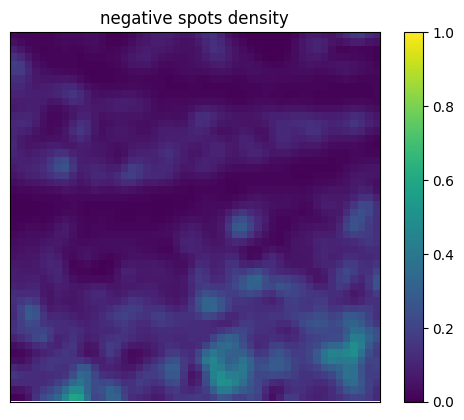

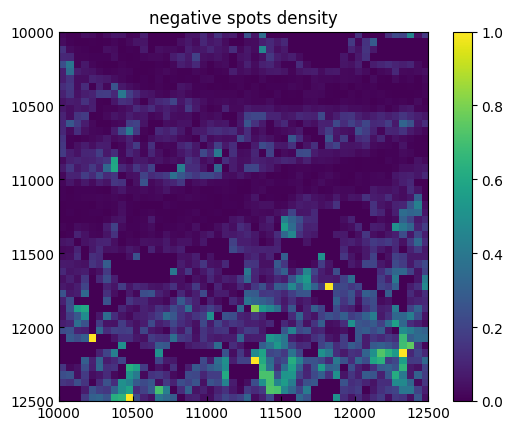

In [133]:
plot_neg_spot_density(df_exp0,10000,12500,10000,12500,image=None,bins = 50, smooth=1)
plot_neg_spot_density(df_exp0,10000,12500,10000,12500,image=None,bins = 50, show_ticks=True)

In [ ]:
def get_spot_density(spots: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """get density of spots that are in celltypes of negative_marker_dict

    Parameters
    ----------
    spots : pd.DataFrame
        pd.DataFrame with columns: gene, x, y, celltype, in_correct_celltype
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of spots reads per bin
    range : range of binning 
    """
     
    if (x_min is None or x_max is None or y_min is None or y_max is None) and image is None:
        raise ValueError("please provide an image or crop")         
        
    if image is None:
        range = [[x_min,x_max],[y_min,y_max]]
    
    else:
        range = [[0,image.shape[0]],[0,image.shape[1]]]
    

    #filter spots
    df = spots
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]

    true_spots = df.loc[df['in_correct_celltype'] != "Unknown"]           #sinnvoll?
    x = true_spots['x']
    y = true_spots['y']
    H, x_edges, y_edges = np.histogram2d(x, y, bins = bins, range = range)
    H = H.T

    return H, range


In [ ]:
get_spot_density(df_exp0,10000,12500,10000,12500,image=None,bins = 20)


In [ ]:
def plot_spot_density(spots: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int,
                      image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    """plot spot density

    Parameters
    ----------
    spots : pd.DataFrame
        pd.DataFrame with columns: gene, x, y, celltype, in_correct_celltype
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    H, range = get_spot_density(spots,x_min,x_max,y_min,y_max,image,bins)
    H = gaussian_filter(H,sigma=smooth)
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]


    fig = plt.figure()
    ax = fig.add_subplot(title='spots density') 
    plot = plt.imshow(H, interpolation='nearest',
            extent=[x_min, x_max, y_max, y_min], #norm= mpl.colors.Normalize.__call__(self,value=H)
            )
    fig.colorbar(plot)

    if show_ticks:
        ax.tick_params(which='both', direction='in')
    else:
        ax.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)


In [ ]:
plot_spot_density(df_exp0,10000,12500,10000,12500,image=None,bins = 50, show_ticks=True)

In [ ]:
def get_cells_df(spots: pd.DataFrame):
    """get cell location DataFrame

    Parameters
    ----------
    spots : pd.DataFrame
        pd.DataFrame with columns: gene, x, y, celltype, in_correct_celltype
    Returns
    -------
        DataFrame with columns: cell, celltype, x, y
    """
    df_cells = spots.loc[spots["in_correct_celltype"]=="True"]
    df_cells = df_cells.groupby(["cell","celltype"])[["x","y"]].mean()
    df_cells = df_cells.reset_index().rename(columns={'cell':'cell', 'celltype':'celltype'})


    return df_cells

In [ ]:
df_cells = get_cells_df(df_exp0)
df_cells

In [ ]:
len(df_cells["cell"].unique())
# df_cells.loc[df_cells["cell"]==5.0]

In [ ]:
df_t = pd.merge(df_cells,adata_exp0.obs,left_on="cell",right_on="cell_id",how="inner")      
df_t.drop(["celltype_y"],axis=1)
df_t.rename(columns={"celltype_x": "celltype"})

#TODO: assign it to adata_exp0.obs, ?different lengths

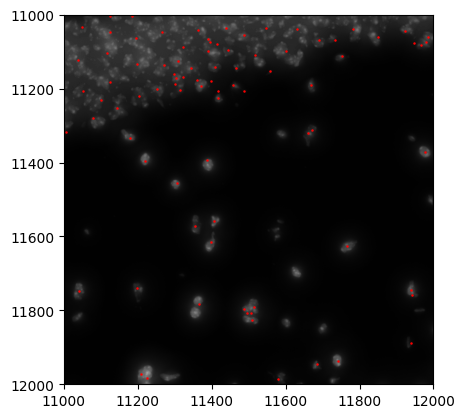

In [135]:
df = df_cells  
x_min, x_max, y_max, y_min = 11000, 12000, 12000, 11000

fig, ax = plt.subplots()
ax.axis([x_min, x_max, y_max, y_min])        
ax.imshow(image,cmap = "binary_r") 

#filter spots
df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]

ax.scatter(df['x'], df['y'], s = 0.6, color = "red")

In [ ]:
def get_cell_density(df_cells: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """get cell density

    Parameters
    ----------
    df_cells : pd.DataFrame
        pd.DataFrame with columns: cell, celltype, x, y
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of cells per bin
    range : range of binning 
    """
     
    if (x_min is None or x_max is None or y_min is None or y_max is None) and image is None:
        raise ValueError("please provide an image or crop")         
        
    if image is None:
        range = [[x_min,x_max],[y_min,y_max]]
    
    else:
        range = [[0,image.shape[0]],[0,image.shape[1]]]
    
    df = df_cells

    x = df['x']
    y = df['y']
    H, x_edges, y_edges = np.histogram2d(x, y, bins = bins, range = range)
    H = H.T

    return H, range

In [ ]:
get_cell_density(df_cells,10000,12500,10000,12500,image=None,bins = 20)

In [ ]:
def plot_cell_density(df_cells: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int,
                      image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    """plot cell density

    Parameters
    ----------
    df_cells : pd.DataFrame
        pd.DataFrame with columns: cell, celltype, x, y
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    H, range = get_cell_density(df_cells,x_min,x_max,y_min,y_max,image,bins)
    H = gaussian_filter(H,sigma=smooth)
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]


    fig = plt.figure()
    ax = fig.add_subplot(title='cell density') 
    plot = plt.imshow(H, interpolation='nearest',
            extent=[x_min, x_max, y_max, y_min], #norm= mpl.colors.Normalize.__call__(self,value=H)
            )
    fig.colorbar(plot)

    if show_ticks:
        ax.tick_params(which='both', direction='in')
    else:
        ax.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)

In [ ]:
plot_cell_density(df_cells,10000,12500,10000,12500,image=None,bins = 40)

In [ ]:
def get_cell_heterogenity(df_cells: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """get number of different celltypes per bin
    Parameters
    ----------
    df_cells: pd.DataFrame
        pd.DataFrame with columns: cell, celltype, x, y
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    result : array of ints
        number of different celltypes per bin
    range : range of binning    
    """
    if (x_min is None or x_max is None or y_min is None or y_max is None) and image is None:
        raise ValueError("please provide an image or crop")         
        
    if image is None:
        range = [[x_min,x_max],[y_min,y_max]]
    
    else:
        range = [[0,image.shape[0]],[0,image.shape[1]]]
    
    #filter cells
    df = df_cells
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]
    
    
    x_bins = np.linspace(x_min,x_max,bins +1)
    y_bins = np.linspace(y_min,y_max,bins +1)

    df['x_bin'] = np.digitize(df['x'], x_bins, right=True) - 1
    df['y_bin'] = np.digitize(df['y'], y_bins, right=True) - 1

    grouped = df.groupby(['x_bin', 'y_bin'])['celltype'].apply(lambda x: len(x.unique()))

    result = np.zeros((bins, bins))
    for (x, y), count in grouped.items():
        result[x - 1, y - 1] = count
        
    return result, range

    

In [ ]:
get_cell_heterogenity(df_cells,10000,12500,10000,12500,image=None,bins = 20)  #fix warnings

In [ ]:
def plot_cell_heterogenity(df_cells: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int,
                      image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    """plot cell density

    Parameters
    ----------
    df_cells: pd.DataFrame
        pd.DataFrame with columns: cell, celltype, x, y
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    H, range = get_cell_heterogenity(df_cells,x_min,x_max,y_min,y_max,image,bins)
    H = gaussian_filter(H,sigma=smooth)
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]


    fig = plt.figure()
    ax = fig.add_subplot(title='cell heterogenity') 
    plot = plt.imshow(H, interpolation='nearest',
            extent=[x_min, x_max, y_max, y_min], #norm= mpl.colors.Normalize.__call__(self,value=H)
            )
    fig.colorbar(plot)

    if show_ticks:
        ax.tick_params(which='both', direction='in')
    else:
        ax.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)

In [ ]:
plot_cell_heterogenity(df_cells,10000,12500,10000,12500,image=None,bins = 40)

In [ ]:
def get_celltype_density(df_cells: pd.DataFrame, celltype: str, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """get celltype density

    Parameters
    ----------
    df_cells : pd.DataFrame
        pd.DataFrame with columns: cell, celltype, x, y
    celltype : str
        celltype
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of celltype per bin
    range : range of binning 
    """
     
    if (x_min is None or x_max is None or y_min is None or y_max is None) and image is None:
        raise ValueError("please provide an image or crop")         
        
    if image is None:
        range = [[x_min,x_max],[y_min,y_max]]
    
    else:
        range = [[0,image.shape[0]],[0,image.shape[1]]]
    
    df = df_cells

    H_total, x_edges, y_edges = np.histogram2d(df['x'],df['y'], bins = bins, range = range)

    df = df.loc[df["celltype"]==celltype]

    H_celltype, x_edges, y_edges = np.histogram2d(df['x'],df['y'], bins = bins, range = range)
    H = H_celltype/H_total
    H[np.isnan(H)] = 0     #0 cells therefore also 0% celltype in the respective area
    
    H = H.T

    return H, range

In [ ]:
get_celltype_density(df_cells,"CA3", 10000,12500,10000,12500,image=None,bins = 20)


In [ ]:
def plot_celltype_density(df_cells: pd.DataFrame, celltype: str, x_min: int, x_max: int, y_min: int, y_max: int,
                      image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    """plot cell density

    Parameters
    ----------
    df_cells: pd.DataFrame
        pd.DataFrame with columns: cell, celltype, x, y
    celltype : str
        celltype
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    H, range = get_celltype_density(df_cells,celltype,x_min,x_max,y_min,y_max,image,bins)
    H = gaussian_filter(H,sigma=smooth)
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]


    fig = plt.figure()
    ax = fig.add_subplot(title='celltype density') 
    plot = plt.imshow(H, interpolation='nearest',
            extent=[x_min, x_max, y_max, y_min], #norm= mpl.colors.Normalize.__call__(self,value=H)
            )
    fig.colorbar(plot)

    if show_ticks:
        ax.tick_params(which='both', direction='in')
    else:
        ax.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)

In [ ]:
plot_celltype_density(df_cells,"CA3", 10000,12500,10000,12500,image=None,bins = 20)

In [155]:
def get_correlate_mats(mat_1: np.ndarray, mat_2: np.ndarray):
    """compute the row-wise Pearson correlation coefficients between mat_1 and mat_2
       
    To do this, we compute the correlation coefficients between the rows: (1,n+1),(2,n+2),(3,n+3),...,(n,2*n) 
    where the first entry references rows in mat_1. 
    mat_1 and mat_2 should have the same shape
    Parameters
    ----------
    mat_1: np.ndarray
        first matrix
    mat_2: np.ndarray
        second matrix
    Returns
    -------
    coeff_vec: np.ndarray
        vector of row-wise coefficients
    """
    n = mat_1.shape[0]
    indices = np.arange(n)
    coeff_mat = np.corrcoef(mat_1,mat_2)
    coeff_vec = coeff_mat[indices,n+indices]

    return coeff_vec

In [156]:
get_correlate_mats(neg_spot_dens,cell_dens)

array([-0.36938587, -0.52702846, -0.10805284, -0.23608891,  0.05468215,
       -0.20213662, -0.41706077, -0.46298646, -0.12470711, -0.37307987,
       -0.34033343, -0.2451877 , -0.06420919, -0.43931149,  0.04007777,
       -0.17746424,  0.05294124,  0.17750865, -0.29449346, -0.06880949])